In [1]:
import torch.nn.functional as Fun
import torch
from torch import nn
import torchvision.transforms as transforms
import numpy as np
import random

random_seed = 100  
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from torch.utils.data import (
    Dataset,
    DataLoader,
)
"""Здесь обучается лучшая модель которая различает все метки"""

In [2]:
class PizzaDataset(Dataset):
    def __init__(self, csv_file="train.csv", root="train_196", transform=None, target_transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.root, self.labels.iloc[index, 1])
        img_path = os.path.join(self.root, img_path)
        image = Image.open(img_path)
        label = torch.tensor(int(self.labels.iloc[index, 2]))

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
training_data = PizzaDataset(
    csv_file="train1.csv",
    root="train_196",
    transform=transforms.Compose([transforms.RandomChoice([transforms.RandomVerticalFlip(), 
                                                           transforms.RandomHorizontalFlip(), 
                                                           transforms.RandomRotation(45)]), 
                                  transforms.ToTensor()]),
    target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

test_data = PizzaDataset(
    csv_file="labels.csv",
    root="test_196",
    transform=transforms.ToTensor(),
    target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

In [4]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2556712260.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel

Original Images


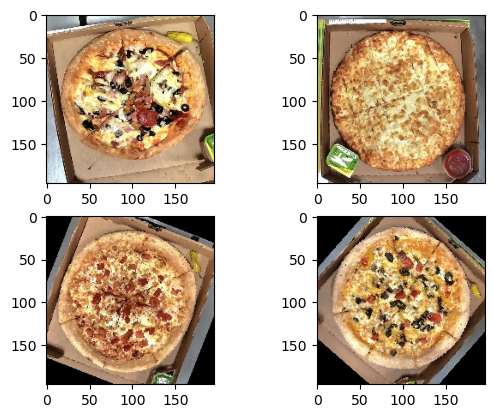

CutMix Images


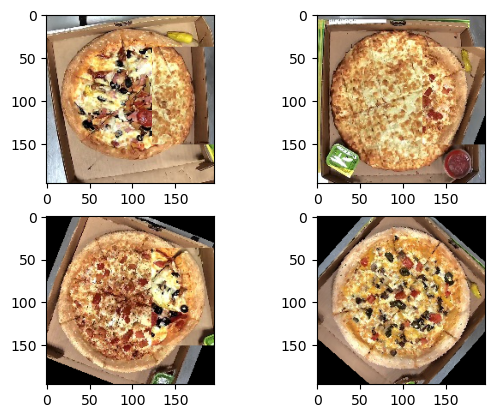

CutMix Images


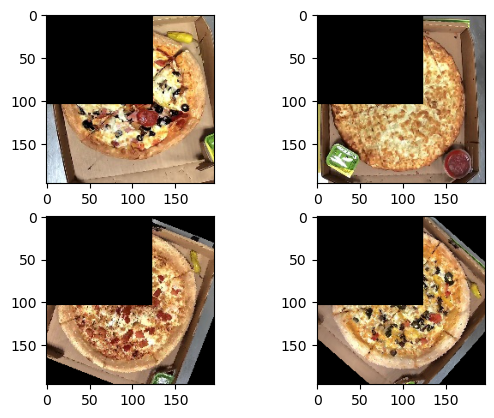

Original labels:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Updated labels
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [5]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    #print(lam)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0][0].shape, lam)
    image_batch_updated = image_batch.numpy().copy()
    image_batch_updated[:, :, bbx1:bbx2, bby1:bby2] = image_batch[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[3] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return torch.Tensor(image_batch_updated),label

def generate_cutout_image(image_batch, image_batch_labels, beta):
    """ Generate a CutOut augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutOut image batch, labels
    """
    # generate cutout sample
    lam = np.random.beta(beta, beta)
    #print(lam)
    target_a = image_batch_labels
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0][0].shape, lam)
    image_batch_updated = image_batch.numpy().copy()
    zero_image = np.zeros(image_batch_updated[0].shape)
    image_batch_updated[:, :, bbx1:bbx2, bby1:bby2] = zero_image[:, bbx1:bbx2, bby1:bby2]
    
    return torch.Tensor(image_batch_updated), image_batch_labels

# Generate CutMix image
# Let's use the first image of the batch as the input image to be augmented
for x, y in train_dataloader:
    image_batch = x
    image_batch_labels = y
    break
input_image = image_batch[0]
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch[:4], image_batch_labels[:4], 1.0)

# Show original images
print("Original Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch[2*i+j].numpy())
        plt.imshow(np.moveaxis(image_batch[2*i+j].numpy(),0,-1))
plt.show()


# Show CutMix images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch_updated[2*i+j])
        plt.imshow(np.moveaxis(image_batch_updated[2*i+j].numpy(),0,-1))
plt.show()
image_batch_updated, image_batch_labels_updated = generate_cutout_image(image_batch[:4], image_batch_labels[:4], 1.0)
# Show CutOut images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch_updated[2*i+j])
        plt.imshow(np.moveaxis(image_batch_updated[2*i+j].numpy(),0,-1))
plt.show()

# Print labels
print('Original labels:')
print(image_batch_labels)
print('Updated labels')
print(image_batch_labels_updated)

['альфредо', 'баварская', 'вегетарианская', 'ветчинаибекон', 'ветчинаигрибы', 'гавайская', 'грушаbbq', 'капричиоза', 'клубникаизефир', 'крем-чизсгрибами', 'любимаядедамороза', 'любимаякарбонара', 'любимаяпапинапицца', 'маленькаяиталия', 'маргарита', 'мексиканская', 'миксгрин', 'мясная', 'мясноебарбекю', 'новогодняя', 'палочки', 'папамикс', 'пепперони', 'пепперонигрин', 'пицца8сыровnew', 'постная', 'рождественская', 'сананасомибеконом', 'сгрушейибеконом', 'сгрушейиголубымсыром', 'сердцепепперони-4сыра', 'сердцецыпленокбарбекю-пепперони', 'сливочнаяскреветками', 'суперпапа', 'сырная', 'томатнаяскреветками', 'улыбка', 'цыпленокбарбекю', 'цыпленокгрин', 'цыпленоккордонблю', 'цыпленокрэнч', 'цыпленокфлорентина', 'чеддермексикан', 'чеддерчизбургер', 'четыресыра', 'чизбургер']


C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)


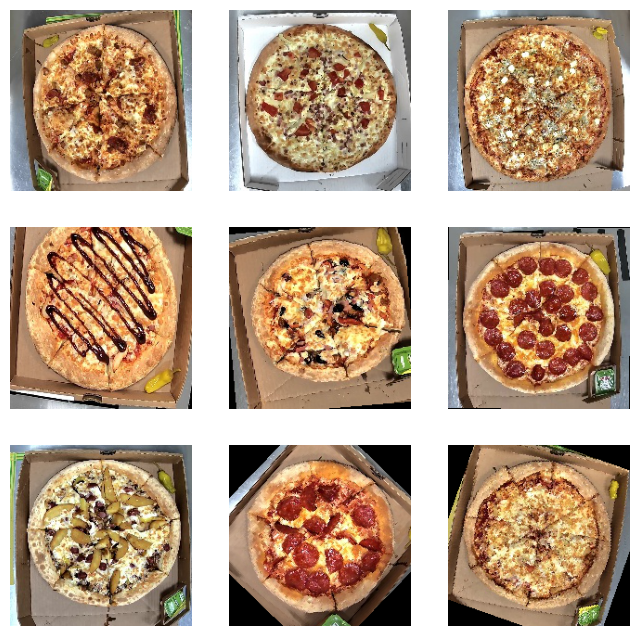

In [6]:
classes = """0: альфредо
1: баварская
2: вегетарианская
3: ветчинаибекон
4: ветчинаигрибы
5: гавайская
6: грушаbbq
7: капричиоза
8: клубникаизефир
9: крем-чизсгрибами
10: любимаядедамороза
11: любимаякарбонара
12: любимаяпапинапицца
13: маленькаяиталия
14: маргарита
15: мексиканская
16: миксгрин
17: мясная
18: мясноебарбекю
19: новогодняя
20: палочки
21: папамикс
22: пепперони
23: пепперонигрин
24: пицца8сыровnew
25: постная
26: рождественская
27: сананасомибеконом
28: сгрушейибеконом
29: сгрушейиголубымсыром
30: сердцепепперони-4сыра
31: сердцецыпленокбарбекю-пепперони
32: сливочнаяскреветками
33: суперпапа
34: сырная
35: томатнаяскреветками
36: улыбка
37: цыпленокбарбекю
38: цыпленокгрин
39: цыпленоккордонблю
40: цыпленокрэнч
41: цыпленокфлорентина
42: чеддермексикан
43: чеддерчизбургер
43: четыресыра
45: чизбургер"""

labels = classes.split()[1::2]
print(labels)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # Случайный индекс из датасета
    img, label = training_data[sample_idx] # Обращение по такому индексу возвращает изображение и метку элемента датасета
    figure.add_subplot(rows, cols, i)
    #plt.title(labels[label])
    plt.axis("off")
    plt.imshow(np.moveaxis(img.numpy(),0,-1))
plt.show()

In [7]:
img.numpy().shape

(3, 196, 196)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
torch.cuda.empty_cache()

Using cuda device


In [9]:
from torchvision.models import regnet_y_3_2gf, RegNet_Y_3_2GF_Weights

weights = RegNet_Y_3_2GF_Weights.DEFAULT
model = regnet_y_3_2gf(weights=weights)#preprocess is also here
model.to(device)
model.train()

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            

In [10]:
loss_fn = nn.CrossEntropyLoss()

In [11]:
learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))

In [12]:
from tqdm import tqdm
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Получаем предсказания модели для данного батча
        p = np.random.random()
        if p>0.5:
            X, y = generate_cutmix_image(X, y, 1.0)
        else:
            X, y = generate_cutout_image(X, y, 1.0)
        X,y = X.to(device),y.to(device)
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test_loop(dataloader, model, loss_fn, loss_list, acc_list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_list.append(test_loss)
    acc_list.append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
def sent_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            preds.append(pred.cpu().numpy().argmax(1)[0])
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return preds

In [22]:
def sent_loop1(dataloader, model, amodel, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            if pred.cpu().numpy().argmax(1)[0] in [5, 6, 9, 27, 28, 29, 33, 13, 14]:
                pred = amodel(X)
            preds.append(pred.cpu().numpy().argmax(1)[0])
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return preds

In [15]:
loss_list = []
acc_list = []

In [16]:
epochs = 20
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2556712260.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/d

Epoch 1
-------------------------------
loss: 7.365263  [    0/ 6379]
loss: 0.915764  [ 1280/ 6379]
loss: 2.205200  [ 2560/ 6379]
loss: 0.630133  [ 3840/ 6379]
loss: 1.308109  [ 5120/ 6379]


C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  5%|████▏                                                                              | 1/20 [00:24<07:53, 24.91s/it]

Test Error: 
 Accuracy: 77.7%, Avg loss: 0.773593 

Epoch 2
-------------------------------
loss: 1.903159  [    0/ 6379]
loss: 0.281890  [ 1280/ 6379]
loss: 0.413969  [ 2560/ 6379]
loss: 0.301621  [ 3840/ 6379]
loss: 0.593163  [ 5120/ 6379]


 10%|████████▎                                                                          | 2/20 [00:46<06:57, 23.18s/it]

Test Error: 
 Accuracy: 88.7%, Avg loss: 0.429321 

Epoch 3
-------------------------------
loss: 0.746143  [    0/ 6379]
loss: 1.164533  [ 1280/ 6379]
loss: 1.195150  [ 2560/ 6379]
loss: 0.303159  [ 3840/ 6379]
loss: 1.484509  [ 5120/ 6379]


 15%|████████████▍                                                                      | 3/20 [01:08<06:23, 22.58s/it]

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.351482 

Epoch 4
-------------------------------
loss: 0.244263  [    0/ 6379]
loss: 0.807466  [ 1280/ 6379]
loss: 0.948138  [ 2560/ 6379]
loss: 0.133505  [ 3840/ 6379]
loss: 1.058161  [ 5120/ 6379]


 20%|████████████████▌                                                                  | 4/20 [01:30<05:56, 22.28s/it]

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.238881 

Epoch 5
-------------------------------
loss: 1.329556  [    0/ 6379]
loss: 0.990707  [ 1280/ 6379]
loss: 1.124533  [ 2560/ 6379]
loss: 1.288477  [ 3840/ 6379]
loss: 0.337680  [ 5120/ 6379]


 25%|████████████████████▊                                                              | 5/20 [01:52<05:32, 22.16s/it]

Test Error: 
 Accuracy: 68.5%, Avg loss: 1.133646 

Epoch 6
-------------------------------
loss: 0.187261  [    0/ 6379]
loss: 0.118758  [ 1280/ 6379]
loss: 1.054058  [ 2560/ 6379]
loss: 0.111684  [ 3840/ 6379]
loss: 0.973928  [ 5120/ 6379]


 30%|████████████████████████▉                                                          | 6/20 [02:14<05:09, 22.10s/it]

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.336048 

Epoch 7
-------------------------------
loss: 0.992370  [    0/ 6379]
loss: 0.073341  [ 1280/ 6379]
loss: 1.397922  [ 2560/ 6379]
loss: 1.165228  [ 3840/ 6379]
loss: 0.958825  [ 5120/ 6379]


 35%|█████████████████████████████                                                      | 7/20 [02:36<04:46, 22.07s/it]

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.275615 

Epoch 8
-------------------------------
loss: 1.207377  [    0/ 6379]
loss: 0.656902  [ 1280/ 6379]
loss: 0.027728  [ 2560/ 6379]
loss: 1.150171  [ 3840/ 6379]
loss: 0.216611  [ 5120/ 6379]


 40%|█████████████████████████████████▏                                                 | 8/20 [02:58<04:23, 21.99s/it]

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.313586 

Epoch 9
-------------------------------
loss: 1.002393  [    0/ 6379]
loss: 0.350381  [ 1280/ 6379]
loss: 1.096334  [ 2560/ 6379]
loss: 1.023835  [ 3840/ 6379]
loss: 0.796150  [ 5120/ 6379]


 45%|█████████████████████████████████████▎                                             | 9/20 [03:20<04:01, 21.94s/it]

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.416229 

Epoch 10
-------------------------------
loss: 0.913219  [    0/ 6379]
loss: 1.073535  [ 1280/ 6379]
loss: 1.106022  [ 2560/ 6379]
loss: 0.088311  [ 3840/ 6379]
loss: 2.025528  [ 5120/ 6379]


 50%|█████████████████████████████████████████                                         | 10/20 [03:42<03:39, 21.94s/it]

Test Error: 
 Accuracy: 95.6%, Avg loss: 0.196890 

Epoch 11
-------------------------------
loss: 0.068836  [    0/ 6379]
loss: 0.378479  [ 1280/ 6379]
loss: 1.627529  [ 2560/ 6379]
loss: 0.691725  [ 3840/ 6379]
loss: 1.080016  [ 5120/ 6379]


 55%|█████████████████████████████████████████████                                     | 11/20 [04:04<03:17, 21.95s/it]

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.257341 

Epoch 12
-------------------------------
loss: 0.095572  [    0/ 6379]
loss: 1.118072  [ 1280/ 6379]
loss: 0.136182  [ 2560/ 6379]
loss: 0.281272  [ 3840/ 6379]
loss: 0.200212  [ 5120/ 6379]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [04:25<02:55, 21.92s/it]

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.202621 

Epoch 13
-------------------------------
loss: 0.960074  [    0/ 6379]
loss: 0.961793  [ 1280/ 6379]
loss: 0.029583  [ 2560/ 6379]
loss: 0.115221  [ 3840/ 6379]
loss: 0.130059  [ 5120/ 6379]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [04:48<02:34, 22.03s/it]

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.222568 

Epoch 14
-------------------------------
loss: 0.666949  [    0/ 6379]
loss: 0.632180  [ 1280/ 6379]
loss: 0.139262  [ 2560/ 6379]
loss: 0.152113  [ 3840/ 6379]
loss: 0.151601  [ 5120/ 6379]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [05:10<02:11, 21.97s/it]

Test Error: 
 Accuracy: 95.8%, Avg loss: 0.195384 

Epoch 15
-------------------------------
loss: 1.109885  [    0/ 6379]
loss: 1.106058  [ 1280/ 6379]
loss: 0.032077  [ 2560/ 6379]
loss: 0.077728  [ 3840/ 6379]
loss: 0.075817  [ 5120/ 6379]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [05:32<01:49, 21.98s/it]

Test Error: 
 Accuracy: 93.9%, Avg loss: 0.254469 

Epoch 16
-------------------------------
loss: 0.146822  [    0/ 6379]
loss: 0.039499  [ 1280/ 6379]
loss: 2.318872  [ 2560/ 6379]
loss: 1.177633  [ 3840/ 6379]
loss: 0.527492  [ 5120/ 6379]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [05:54<01:27, 21.99s/it]

Test Error: 
 Accuracy: 96.8%, Avg loss: 0.189117 

Epoch 17
-------------------------------
loss: 0.003191  [    0/ 6379]
loss: 0.285897  [ 1280/ 6379]
loss: 0.068838  [ 2560/ 6379]
loss: 1.172613  [ 3840/ 6379]
loss: 0.195432  [ 5120/ 6379]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [06:16<01:06, 22.11s/it]

Test Error: 
 Accuracy: 96.8%, Avg loss: 0.188196 

Epoch 18
-------------------------------
loss: 0.153268  [    0/ 6379]
loss: 1.173910  [ 1280/ 6379]
loss: 0.575134  [ 2560/ 6379]
loss: 0.065805  [ 3840/ 6379]
loss: 0.951050  [ 5120/ 6379]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [06:38<00:44, 22.10s/it]

Test Error: 
 Accuracy: 96.8%, Avg loss: 0.189324 

Epoch 19
-------------------------------
loss: 0.923251  [    0/ 6379]
loss: 0.135104  [ 1280/ 6379]
loss: 0.100137  [ 2560/ 6379]
loss: 1.045246  [ 3840/ 6379]
loss: 0.814818  [ 5120/ 6379]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [07:00<00:21, 21.97s/it]

Test Error: 
 Accuracy: 96.3%, Avg loss: 0.194755 

Epoch 20
-------------------------------
loss: 0.911906  [    0/ 6379]
loss: 0.714869  [ 1280/ 6379]
loss: 1.992583  [ 2560/ 6379]
loss: 0.064835  [ 3840/ 6379]
loss: 0.060217  [ 5120/ 6379]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:22<00:00, 22.10s/it]

Test Error: 
 Accuracy: 95.9%, Avg loss: 0.227841 

Done!


In [17]:
learning_rate = 1e-4
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))
epochs = 20
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------


C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2556712260.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel

loss: 0.008717  [    0/ 6379]
loss: 0.995330  [ 1280/ 6379]
loss: 0.162252  [ 2560/ 6379]
loss: 0.011421  [ 3840/ 6379]
loss: 0.005217  [ 5120/ 6379]


C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  5%|████▏                                                                              | 1/20 [00:21<06:53, 21.74s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.163661 

Epoch 2
-------------------------------
loss: 0.751448  [    0/ 6379]
loss: 0.670000  [ 1280/ 6379]
loss: 0.770377  [ 2560/ 6379]
loss: 0.053057  [ 3840/ 6379]
loss: 0.603808  [ 5120/ 6379]


 10%|████████▎                                                                          | 2/20 [00:43<06:31, 21.74s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.161272 

Epoch 3
-------------------------------
loss: 0.579355  [    0/ 6379]
loss: 0.764855  [ 1280/ 6379]
loss: 0.069328  [ 2560/ 6379]
loss: 0.820875  [ 3840/ 6379]
loss: 0.483202  [ 5120/ 6379]


 15%|████████████▍                                                                      | 3/20 [01:05<06:09, 21.71s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.177192 

Epoch 4
-------------------------------
loss: 0.801791  [    0/ 6379]
loss: 0.667513  [ 1280/ 6379]
loss: 0.547603  [ 2560/ 6379]
loss: 0.010220  [ 3840/ 6379]
loss: 0.030929  [ 5120/ 6379]


 20%|████████████████▌                                                                  | 4/20 [01:26<05:47, 21.70s/it]

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.163342 

Epoch 5
-------------------------------
loss: 0.003462  [    0/ 6379]
loss: 1.090758  [ 1280/ 6379]
loss: 0.003760  [ 2560/ 6379]
loss: 0.007127  [ 3840/ 6379]
loss: 0.033459  [ 5120/ 6379]


 25%|████████████████████▊                                                              | 5/20 [01:48<05:25, 21.67s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.166241 

Epoch 6
-------------------------------
loss: 0.727118  [    0/ 6379]
loss: 0.006033  [ 1280/ 6379]
loss: 0.863052  [ 2560/ 6379]
loss: 0.075567  [ 3840/ 6379]
loss: 3.353369  [ 5120/ 6379]


 30%|████████████████████████▉                                                          | 6/20 [02:10<05:04, 21.72s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.170345 

Epoch 7
-------------------------------
loss: 1.244522  [    0/ 6379]
loss: 0.031276  [ 1280/ 6379]
loss: 0.005035  [ 2560/ 6379]
loss: 0.828784  [ 3840/ 6379]
loss: 0.026737  [ 5120/ 6379]


 35%|█████████████████████████████                                                      | 7/20 [02:32<04:42, 21.74s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.172577 

Epoch 8
-------------------------------
loss: 0.046394  [    0/ 6379]
loss: 1.170018  [ 1280/ 6379]
loss: 0.001985  [ 2560/ 6379]
loss: 0.835350  [ 3840/ 6379]
loss: 0.013212  [ 5120/ 6379]


 40%|█████████████████████████████████▏                                                 | 8/20 [02:54<04:22, 21.84s/it]

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.162506 

Epoch 9
-------------------------------
loss: 0.951616  [    0/ 6379]
loss: 0.803709  [ 1280/ 6379]
loss: 0.035447  [ 2560/ 6379]
loss: 0.134082  [ 3840/ 6379]
loss: 0.028205  [ 5120/ 6379]


 45%|█████████████████████████████████████▎                                             | 9/20 [03:16<04:01, 21.93s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.159293 

Epoch 10
-------------------------------
loss: 0.703376  [    0/ 6379]
loss: 0.842460  [ 1280/ 6379]
loss: 0.589492  [ 2560/ 6379]
loss: 0.621066  [ 3840/ 6379]
loss: 0.043676  [ 5120/ 6379]


 50%|█████████████████████████████████████████                                         | 10/20 [03:38<03:39, 21.93s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.172812 

Epoch 11
-------------------------------
loss: 0.106392  [    0/ 6379]
loss: 0.007579  [ 1280/ 6379]
loss: 0.717551  [ 2560/ 6379]
loss: 0.607748  [ 3840/ 6379]
loss: 0.003873  [ 5120/ 6379]


 55%|█████████████████████████████████████████████                                     | 11/20 [04:00<03:17, 21.98s/it]

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.169073 

Epoch 12
-------------------------------
loss: 0.763219  [    0/ 6379]
loss: 0.619057  [ 1280/ 6379]
loss: 0.648009  [ 2560/ 6379]
loss: 0.016724  [ 3840/ 6379]
loss: 0.617606  [ 5120/ 6379]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [04:22<02:55, 21.91s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.163690 

Epoch 13
-------------------------------
loss: 0.043407  [    0/ 6379]
loss: 0.673673  [ 1280/ 6379]
loss: 0.568817  [ 2560/ 6379]
loss: 0.001780  [ 3840/ 6379]
loss: 0.661798  [ 5120/ 6379]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [04:44<02:33, 21.98s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.166225 

Epoch 14
-------------------------------
loss: 0.645389  [    0/ 6379]
loss: 0.011210  [ 1280/ 6379]
loss: 1.266676  [ 2560/ 6379]
loss: 0.532801  [ 3840/ 6379]
loss: 0.721972  [ 5120/ 6379]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [05:05<02:11, 21.87s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.187846 

Epoch 15
-------------------------------
loss: 0.004366  [    0/ 6379]
loss: 0.676109  [ 1280/ 6379]
loss: 0.601925  [ 2560/ 6379]
loss: 0.002383  [ 3840/ 6379]
loss: 0.606510  [ 5120/ 6379]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [05:27<01:49, 21.81s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.173767 

Epoch 16
-------------------------------
loss: 0.005327  [    0/ 6379]
loss: 0.005211  [ 1280/ 6379]
loss: 2.578911  [ 2560/ 6379]
loss: 0.004699  [ 3840/ 6379]
loss: 1.043615  [ 5120/ 6379]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [05:49<01:27, 21.83s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.168726 

Epoch 17
-------------------------------
loss: 0.071543  [    0/ 6379]
loss: 0.618596  [ 1280/ 6379]
loss: 0.001592  [ 2560/ 6379]
loss: 0.805247  [ 3840/ 6379]
loss: 0.810779  [ 5120/ 6379]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [06:10<01:05, 21.73s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.153912 

Epoch 18
-------------------------------
loss: 0.068455  [    0/ 6379]
loss: 1.368433  [ 1280/ 6379]
loss: 0.328246  [ 2560/ 6379]
loss: 0.627738  [ 3840/ 6379]
loss: 0.478395  [ 5120/ 6379]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [06:32<00:43, 21.65s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.183556 

Epoch 19
-------------------------------
loss: 0.910445  [    0/ 6379]
loss: 0.000999  [ 1280/ 6379]
loss: 0.104124  [ 2560/ 6379]
loss: 0.007550  [ 3840/ 6379]
loss: 0.335467  [ 5120/ 6379]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [06:53<00:21, 21.62s/it]

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.177865 

Epoch 20
-------------------------------
loss: 0.683618  [    0/ 6379]
loss: 0.663623  [ 1280/ 6379]
loss: 0.097318  [ 2560/ 6379]
loss: 0.752827  [ 3840/ 6379]
loss: 0.570062  [ 5120/ 6379]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:15<00:00, 21.77s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.157666 

Done!


In [18]:
learning_rate = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))
epochs = 11
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

Epoch 1
-------------------------------


C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2556712260.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel

loss: 0.919977  [    0/ 6379]
loss: 0.094722  [ 1280/ 6379]
loss: 0.004938  [ 2560/ 6379]
loss: 0.002134  [ 3840/ 6379]
loss: 0.563395  [ 5120/ 6379]


C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  9%|███████▌                                                                           | 1/11 [00:21<03:35, 21.54s/it]

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.159930 

Epoch 2
-------------------------------
loss: 0.879817  [    0/ 6379]
loss: 0.657497  [ 1280/ 6379]
loss: 0.002968  [ 2560/ 6379]
loss: 0.004764  [ 3840/ 6379]
loss: 0.372960  [ 5120/ 6379]


 18%|███████████████                                                                    | 2/11 [00:43<03:13, 21.52s/it]

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.164599 

Epoch 3
-------------------------------
loss: 0.002238  [    0/ 6379]
loss: 0.378841  [ 1280/ 6379]
loss: 0.002263  [ 2560/ 6379]
loss: 0.628254  [ 3840/ 6379]
loss: 0.063651  [ 5120/ 6379]


 27%|██████████████████████▋                                                            | 3/11 [01:04<02:52, 21.52s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.164936 

Epoch 4
-------------------------------
loss: 0.002271  [    0/ 6379]
loss: 0.002681  [ 1280/ 6379]
loss: 0.000764  [ 2560/ 6379]
loss: 0.001149  [ 3840/ 6379]
loss: 0.612897  [ 5120/ 6379]


 36%|██████████████████████████████▏                                                    | 4/11 [01:26<02:30, 21.53s/it]

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.165216 

Epoch 5
-------------------------------
loss: 0.000687  [    0/ 6379]
loss: 0.588354  [ 1280/ 6379]
loss: 0.682770  [ 2560/ 6379]
loss: 3.454458  [ 3840/ 6379]
loss: 0.000593  [ 5120/ 6379]


 45%|█████████████████████████████████████▋                                             | 5/11 [01:47<02:09, 21.54s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.173985 

Epoch 6
-------------------------------
loss: 0.661864  [    0/ 6379]
loss: 0.021839  [ 1280/ 6379]
loss: 0.634058  [ 2560/ 6379]
loss: 0.656851  [ 3840/ 6379]
loss: 0.715071  [ 5120/ 6379]


 55%|█████████████████████████████████████████████▎                                     | 6/11 [02:09<01:47, 21.53s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.165488 

Epoch 7
-------------------------------
loss: 0.721928  [    0/ 6379]
loss: 0.003904  [ 1280/ 6379]
loss: 0.114928  [ 2560/ 6379]
loss: 0.089758  [ 3840/ 6379]
loss: 0.804854  [ 5120/ 6379]


 64%|████████████████████████████████████████████████████▊                              | 7/11 [02:30<01:26, 21.52s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.179323 

Epoch 8
-------------------------------
loss: 0.057156  [    0/ 6379]
loss: 0.689627  [ 1280/ 6379]
loss: 2.864213  [ 2560/ 6379]
loss: 0.702376  [ 3840/ 6379]
loss: 0.474143  [ 5120/ 6379]


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [02:52<01:04, 21.51s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.182337 

Epoch 9
-------------------------------
loss: 0.547110  [    0/ 6379]
loss: 0.009470  [ 1280/ 6379]
loss: 0.254851  [ 2560/ 6379]
loss: 0.006017  [ 3840/ 6379]
loss: 0.000523  [ 5120/ 6379]


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [03:13<00:43, 21.51s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.182233 

Epoch 10
-------------------------------
loss: 0.803474  [    0/ 6379]
loss: 0.524045  [ 1280/ 6379]
loss: 0.558697  [ 2560/ 6379]
loss: 0.001061  [ 3840/ 6379]
loss: 0.287567  [ 5120/ 6379]


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [03:35<00:21, 21.51s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.183746 

Epoch 11
-------------------------------
loss: 0.000953  [    0/ 6379]
loss: 0.341394  [ 1280/ 6379]
loss: 0.003779  [ 2560/ 6379]
loss: 0.664603  [ 3840/ 6379]
loss: 1.431154  [ 5120/ 6379]


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [03:56<00:00, 21.52s/it]

Test Error: 
 Accuracy: 97.8%, Avg loss: 0.162918 

Done!


In [19]:
checkpoint_filename = "my_bestmodel.pt"
torch.save(model.state_dict(), checkpoint_filename)

0.9775280898876404 50


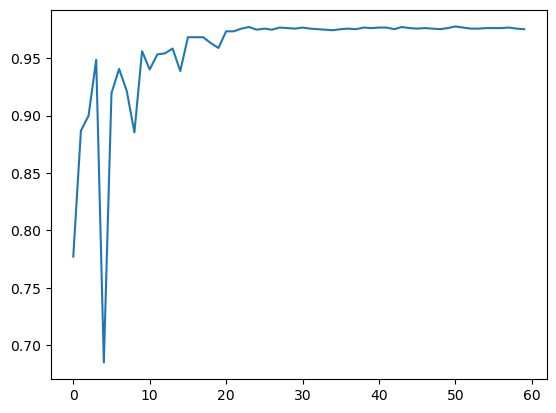

In [19]:
print(max(acc_list),np.argmax(np.array(acc_list)))
plt.plot(acc_list)

In [20]:
sent_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
model.train(False)
preds = sent_loop(sent_dataloader, model, loss_fn)

C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)


Test Error: 
 Accuracy: 97.8%, Avg loss: 0.165749 



In [20]:
print(len(preds))
d = {'id': np.arange(0,2136), 'label': preds}
df=pd.DataFrame(data=d)
print(df)
df.to_csv('Khairullin_Artur.csv', index=False, header=True)

2136
        id  label
0        0      0
1        1      0
2        2      0
3        3      0
4        4      0
...    ...    ...
2131  2131     45
2132  2132     45
2133  2133     45
2134  2134     45
2135  2135     45

[2136 rows x 2 columns]


In [25]:
from torchvision.models import regnet_y_3_2gf, RegNet_Y_3_2GF_Weights
amodel = regnet_y_3_2gf().eval()
state_dict = torch.load("my_ananasmodel.pt")
amodel.load_state_dict(state_dict)
amodel.to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            

In [26]:
sent_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
model.train(False)
amodel.train(False)
preds = sent_loop1(sent_dataloader, model, amodel, loss_fn)

C:\Users\Артур\AppData\Local\Temp\ipykernel_22060\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)


Test Error: 
 Accuracy: 97.8%, Avg loss: 0.192532 



In [27]:
print(len(preds))
d = {'id': np.arange(0,2136), 'label': preds}
df=pd.DataFrame(data=d)
print(df)
df.to_csv('Khairullin_Artur.csv', index=False, header=True)

2136
        id  label
0        0      0
1        1      0
2        2      0
3        3      0
4        4      0
...    ...    ...
2131  2131     45
2132  2132     45
2133  2133     45
2134  2134     45
2135  2135     45

[2136 rows x 2 columns]
